# Checkpoint Selection

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import json
import seaborn as sns

In [23]:
rollout_path = "../assets/rollouts/"
rollout_files = glob.glob(os.path.join(rollout_path, "rollout_results_*k.json"))

# Load all rollout files
results = {}
for file in rollout_files:
    with open(file, "r") as f:
        # Get the filename without the path and extension e.g "merged_task_1_lora"
        filename = os.path.basename(file)
        filename = filename.split(".")[0]
        filename = "_".join(filename.split("_")[2:])
        # Load the json file
        rollout = json.load(f)
        results[filename] = rollout

print(sorted(results.keys()))

['task1_FFT_10k', 'task1_FFT_20k', 'task1_FFT_30k', 'task1_FFT_40k', 'task1_FFT_50k', 'task1_FFT_60k', 'task1_lora_10k', 'task1_lora_20k', 'task2_FFT_10k', 'task2_FFT_20k', 'task2_FFT_30k', 'task2_FFT_40k', 'task2_FFT_50k', 'task2_FFT_60k', 'task2_lora_10k', 'task2_lora_20k', 'task3_FFT_10k', 'task3_FFT_20k', 'task3_FFT_30k', 'task3_FFT_40k', 'task3_FFT_50k', 'task3_FFT_60k', 'task3_lora_10k', 'task3_lora_20k', 'task4_FFT_10k', 'task4_FFT_20k', 'task4_FFT_30k', 'task4_FFT_40k', 'task4_FFT_50k', 'task4_FFT_60k', 'task4_lora_10k', 'task4_lora_20k']


## Combine all results into a single DataFrame

In [24]:
# Create a DataFrame with all the results (no averaging)
df = pd.DataFrame(columns=["task", "lora", "grad_steps", "success", "task_progress", "duration"])
for filename, rollout in results.items():
    # Split filename into merged task (int), lora (bool), grad_steps (int)
    elements = filename.split("_")
    task = elements[0][-1]
    lora = elements[1] == "lora"
    grad_steps = int(elements[2][:-1]) * 1000
    print(task, lora, grad_steps)
    
    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Insert the results into the main DataFrame
    for i in range(len(temp)):
        df.loc[f"{filename}_{i}"] = [task, lora, grad_steps, temp.loc[i, "success"], temp.loc[i, "score"], temp.loc[i, "duration"]]

df

1 True 10000
4 False 60000
3 False 60000
2 False 40000
1 False 30000
2 False 60000
1 False 10000
2 True 10000
3 False 40000
4 False 40000
1 False 50000
2 False 20000
4 True 20000
4 False 20000
3 False 20000
3 True 20000
1 False 20000
2 False 50000
2 True 20000
4 False 50000
3 False 50000
1 True 20000
4 False 10000
3 False 10000
2 False 30000
3 True 10000
1 False 40000
2 False 10000
4 True 10000
1 False 60000
3 False 30000
4 False 30000


,task,lora,grad_steps,success,task_progress,duration
task1_lora_10k_0,1,True,10000,False,0.333333,19.773271
task1_lora_10k_1,1,True,10000,False,0.000000,8.834924
task1_lora_10k_2,1,True,10000,False,0.000000,9.381331
task1_lora_10k_3,1,True,10000,False,0.666667,20.224315
task1_lora_10k_4,1,True,10000,False,0.000000,16.408913
...,...,...,...,...,...,...
task4_FFT_30k_0,4,False,30000,True,1.000000,20.703985
task4_FFT_30k_1,4,False,30000,False,0.000000,30.522152
task4_FFT_30k_2,4,False,30000,False,0.666667,24.282472
task4_FFT_30k_3,4,False,30000,False,0.666667,16.378783


## Average over GradSteps and Training Strategy

In [25]:
## Group by task and lora and calculate the mean ATP
df_avg = df.groupby(["lora", "grad_steps"]).task_progress.mean().reset_index()
df_avg


,lora,grad_steps,task_progress
0,False,10000,0.258333
1,False,20000,0.641667
2,False,30000,0.650000
3,False,40000,0.604167
4,False,50000,0.870833
5,False,60000,0.866667
6,True,10000,0.358333
7,True,20000,0.383333


## Plot

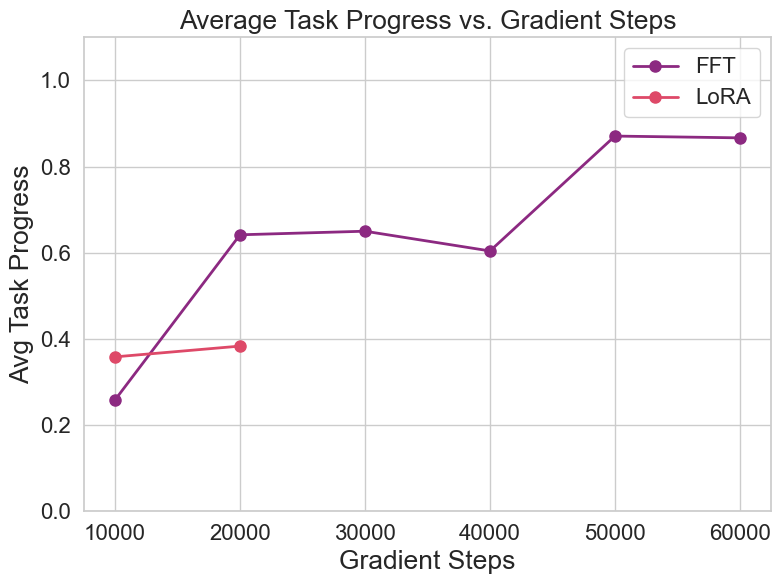

In [26]:
sns.set_theme(style="whitegrid")

font_size = 16
font_size_large = 19

fig, ax = plt.subplots(figsize=(8, 6))

# Separate FFT and LoRA data
df_fft = df_avg[df_avg["lora"] == False]
df_lora = df_avg[df_avg["lora"] == True]

# Use magma palette colors to match the other notebook
palette = sns.color_palette("magma", 4)

ax.plot(df_fft["grad_steps"], df_fft["task_progress"], marker="o", linewidth=2, markersize=8, label="FFT", color=palette[1])
ax.plot(df_lora["grad_steps"], df_lora["task_progress"], marker="o", linewidth=2, markersize=8, label="LoRA", color=palette[2])

ax.set_title("Average Task Progress vs. Gradient Steps", fontsize=font_size_large)
ax.set_xlabel("Gradient Steps", fontsize=font_size_large)
ax.set_ylabel("Avg Task Progress", fontsize=font_size_large)
ax.set_ylim(0, 1.1)
ax.tick_params(axis="both", labelsize=font_size)
ax.legend(fontsize=font_size)

plt.tight_layout()
plt.show()